In [1]:
using Pkg
Pkg.activate("..")

using NCDatasets
using Dates
using CSV, DataFrames
using Statistics
using PyPlot


  Activating project at `~/Projects/cmip6`


In [8]:
"dt2mt(dt) Date to matplotlib date."
dt2mt(dt::Date) = Dates.value(dt) # value in days

"dt2mt(dt) DateTime to matplotlib date."
dt2mt(dt::DateTime) = Dates.value(dt)/86400000 # value in milliseconds -> days

# wrap PyPlot methods to handle julia Dates in the first argument/coordinate
plot(dt::Date, varargs...) = plot(dt2mt(dt), varargs...)
plot(dt::DateTime, varargs...) = plot(dt2mt(dt), varargs...)
contour(dt::Date, varargs...) = contour(dt2mt(dt), varargs...)
contour(dt::DateTime, varargs...) = contour(dt2mt(dt), varargs...)
contourf(dt::Date, varargs...) = contour(dt2mt(dt), varargs...)
contourf(dt::DateTime, varargs...) = contour(dt2mt(dt), varargs...)
pcolormesh(dt::Date, varargs...) = contour(dt2mt(dt), varargs...)
pcolormesh(dt::DateTime, varargs...) = contour(dt2mt(dt), varargs...)

pcolormesh (generic function with 2 methods)

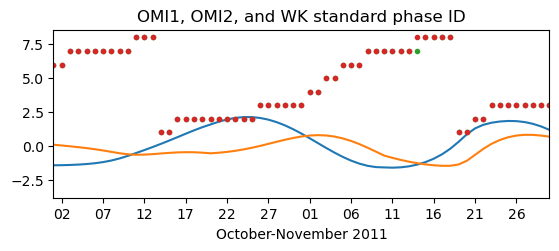

In [52]:
# omi kiladis et al. 2014
omi = CSV.read("./psl_mjoindex/omi.1x.txt", DataFrame,
delim=" ", header=0, ignorerepeated=true)

omidt = Date.(omi[:,1], omi[:,2], omi[:,3])
omi1 = omi[:,5]
omi2 = omi[:,6]
omiampl = omi[:,7]
std(omi2) # 0.907
omiphs = atan.(omi1,-omi2) # phase, Wheeler and Kiladis 1999 convention
omiphs_1 = atan.(omi1,-omi2/std(omi2))
phase_id(x, n=8) = floor(Int,mod(n/(2pi)*x, n)) + 1

clf()
ax1 = subplot(2,1,1)
ax1.plot(dt2mt.(omidt), omi1) # central Indian Oc convection
ax1.plot(dt2mt.(omidt), omi2)
ax1.plot(dt2mt.(omidt), phase_id.(omiphs), marker=".", linestyle="none")
ax1.plot(dt2mt.(omidt), phase_id.(omiphs_1), marker=".", linestyle="none")
ax1.set_xlim(dt2mt.([Date(2011,10,1), Date(2011,11,30)]))
# mpl date formatters
majorformatter = matplotlib[:dates][:DateFormatter]("%d")
majorlocator = matplotlib[:dates][:DayLocator](interval=5)
ax1[:xaxis][:set_major_formatter](majorformatter)
ax1[:xaxis][:set_major_locator](majorlocator)
title("OMI1, OMI2, and WK standard phase ID")
xlabel("October-November 2011")
gcf()


In [40]:
# compare my phases to RMM
rmm = CSV.read("./psl_mjoindex/BOM_RMM.txt", DataFrame, 
    header=2, normalizenames=true,
    delim=" ", ignorerepeated=true,
    select=collect(1:7))
rmmdt = Date.(rmm[!,"year_"],rmm[!,"month_"],rmm[!,"day_"])
# rmm_colnames = ["year", "month", "day", "RMM1", "RMM2", "phase", "amplitude"]

function rmm_phs_id(dt, rmmph=rmm[!,"phase_"])
    ti = findlast(rmmdt .<= dt)
    rmmph[ti]
end

┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 1. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 3. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 5. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 6. Filling 

┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 57. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 58. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 59. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 60. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 61. Filling remaining columns with `missing`
└ @ CSV /home/sdeszoek/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: only found 8 / 12 columns around data row: 62. Fi

rmm_phs_id (generic function with 2 methods)

In [5]:
# ERA5 temperature and specific_humidity
era = NCDataset("ERA5-bl-temperature-easteq.nc")
erat = era[:t][:,:,:,:]
eraq = NCDataset("ERA5-bl-shum-easteq.nc")[:q][:,:,:,:]

# vertical grid
L137_table = CSV.read("L137_table.csv", DataFrame,
    types=[Int64, Float64, Float64, Float64, Union{Missing,Float64}, Union{Missing,Float64}, Float64, Float64, Float64],
    missingstring="-")
galt = zeros(Float64, size(L137_table[119:end,1]))
galt .= L137_table[119:end,"Geometric Altitude [m]"][:]
pres = 0*galt
pres .= L137_table[119:end,"ph [hPa]"]
# get one extra level for the mesh

20-element Vector{Float64}:
  905.7116
  916.0815
  925.7571
  934.7666
  943.1399
  950.9082
  958.1037
  964.7584
  970.9046
  976.5737
  981.7968
  986.6036
  991.023
  995.0824
  998.8081
 1002.225
 1005.3562
 1008.2239
 1010.8487
 1013.25

In [45]:
# blh
blh = NCDataset("ERA5-bl-blh-easteq-1993-2022.nc")
# blh[:time] # DateTime

# subset central Ind Oc
i80 = findall(x-> 78<x<82, blh[:longitude][:])
jeq = findall(x-> -2<x<2 , blh[:latitude][:])
length(i80), length(jeq)

# area average
# mean(blh[:blh][i80,jeq,:], dims=(1,2))[:]  # lon,lat,time

(15, 15)

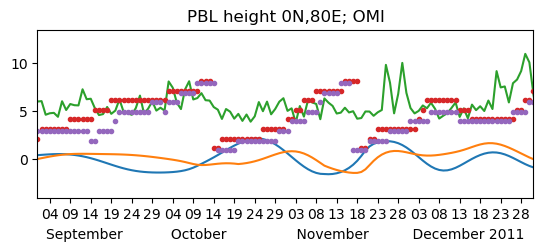

In [54]:
clf()
ax1 = subplot(2,1,1)
ax1.plot(dt2mt.(omidt), omi1) # central Indian Oc convection
ax1.plot(dt2mt.(omidt), omi2)
ax1.plot(dt2mt.(blh[:time]), mean(blh[:blh][i80,jeq,:], dims=(1,2))[:]/100)
ax1.plot(dt2mt.(omidt),  0.1.+phase_id.(omiphs), marker=".", linestyle="none")
ax1.plot(dt2mt.(omidt), -0.1.+rmm_phs_id.(omidt), marker=".", linestyle="none")
ax1.set_xlim(dt2mt.([Date(2011,9,1), Date(2011,12,31)]))
# mpl date formatters
majorformatter = matplotlib[:dates][:DateFormatter]("%d")
majorlocator = matplotlib[:dates][:DayLocator](interval=5)
ax1[:xaxis][:set_major_formatter](majorformatter)
ax1[:xaxis][:set_major_locator](majorlocator)
title("PBL height 0N,80E; OMI")
xlabel("September           October                November          December 2011")
savefig("pblh_omi_dynamo2011.png")
gcf()

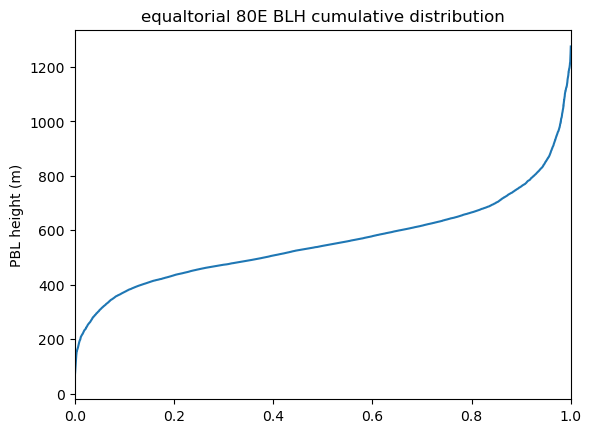

In [120]:
plotcdf(x; kwargs...) = plot((1:length(x))/length(x), sort(x); kwargs...) 

#cumulative distribution of BLH
clf()
# plot(sort(blh[:blh][i80,jeq,:][:]))
plotcdf(blh[:blh][i80,jeq,:][:])
xlim([0, 1])
ylabel("PBL height (m)")
title("equaltorial 80E BLH cumulative distribution")
savefig("pblh_cdf.png")
gcf()

In [63]:
"potential temperature theta(T,p) T Kelvin, p hPa"
theta(t,p; abszerot=0.0, pref=1.0e3) = (t-abszerot) * (pref/p)^0.287

# prealloc saves no time
# erath = zeros(size(erat))

theta

In [64]:
# map along 3rd dimension
erath = [theta(erat[i],pres[i[3]+1]) for i in CartesianIndices(erat)]
# i iterates, taking on each tuple of indices for erat; va;ues i[3]
# offset pres to match vert dim of theta.
# 1.1 s fastest; slow for the recommended way 

# 2.7 s, mapslices slightly slower
# mapslices(t->theta.(t,pres), erat, dims=3)

181×21×19×244 Array{Float64, 4}:
[:, :, 1, 1] =
 302.297  301.367  300.289  299.573  …  295.781  295.449  295.043  294.492
 301.594  300.213  299.115  299.247     295.974  295.251  294.748  294.312
 301.238  299.854  299.474  299.856     296.298  295.345  294.605  294.052
 301.416  299.907  299.705  299.786     296.252  295.523  294.816  294.045
 301.929  300.362  299.696  299.834     296.418  295.614  294.764  293.915
 302.102  301.453  300.183  299.504  …  296.041  295.553  295.177  294.112
 301.791  301.786  300.739  299.635     296.338  295.663  295.067  293.964
 301.175  301.074  300.656  299.901     296.649  296.075  295.619  294.732
 299.81   299.586  300.434  300.117     296.798  296.305  295.878  295.088
 299.405  299.29   300.9    300.558     297.103  296.959  296.411  295.649
   ⋮                                 ⋱                               ⋮
 301.49   301.442  301.301  301.342     301.5    301.624  301.764  301.769
 301.534  301.406  301.181  301.253     301.414  301.684

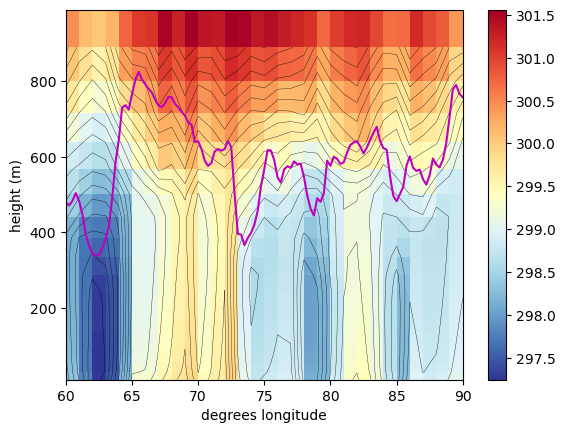

In [67]:
pd = permutedims
anom(x,dims) = x .- mean(x,dims)

# plot lon-vert cross section
clf()
pcolormesh(era[:longitude][61:91], galt[1:end], pd(erath[61:90,11,1:end,1]), 
    shading="flat", cmap=ColorMap("RdYlBu_r"))
colorbar()
contour(era[:longitude][61:91], galt[2:end], pd(erath[61:91,11,:,1]), 
    colors="k", linewidths=0.25, levels= 296.8:0.2:303.2)
plot(blh[:longitude][241:end], blh[:blh][241:end,41,1], color="m")
xlabel("degrees longitude")
ylabel("height (m)")
savefig("th_pblh_lonsect_OctNov2011.png")
gcf()

In [45]:
# select equatorial DYNAMO-ish box
eqbox(era) = findall(x-> -2<=x<=2, era[:latitude])
lonbox(era) = findall(x-> 76<=x<=80, era[:longitude])

size( mean(erath[lonbox(era),eqbox(era),:,:], dims=(1,2))[1,1,:,:] )

(19, 244)

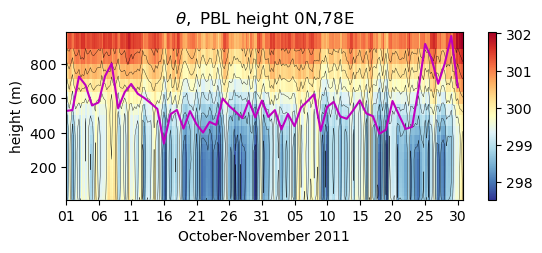

In [80]:
# plot time-height

clf()
ax1 = subplot(2,1,1)
th_th = mean(erath[lonbox(era),eqbox(era),:,:], dims=(1,2))[1,1,:,:]
pcm = ax1.pcolormesh(era[:time][:], galt[1:end], (th_th[1:end,1:end-1]), 
    shading="flat", cmap=ColorMap("RdYlBu_r"))
colorbar(pcm)
ax1.contour(era[:time][:], galt[2:end], timeheight[1:end,1:end], 
    colors="k", 
    linewidths=0.25, levels= 296.8:0.5:303.2)
th_blh = mean( blh[:blh][lonbox(blh),eqbox(blh),:], dims=(1,2) )[1,1,:]
plot(blh[:time][:], th_blh, color="m")
xlabel("degrees longitude")
ylabel("height (m)")
# mpl date formatters
majorformatter = matplotlib[:dates][:DateFormatter]("%d")
majorlocator = matplotlib[:dates][:DayLocator](interval=5)
ax1[:xaxis][:set_major_formatter](majorformatter)
ax1[:xaxis][:set_major_locator](majorlocator)
title(L"\theta,"*" PBL height 0N,78E")
xlabel("October-November 2011")
savefig("th_pblh_timeheight_OctNov2011.png")
gcf()

In [138]:
# composite era theta and BLH on OMI
function omi_phs_id(dt)
    ti = findlast(omidt .<= dt)
    phase_id(omiphs[ti])
end

blhlong = NCDataset("ERA5-bl-blh-easteq-1993-2022.nc") # long BLH record
blhph = omi_phs_id.(blhlong[:time][:])

10957-element Vector{Int64}:
 8
 8
 8
 8
 1
 1
 1
 1
 2
 2
 ⋮
 5
 5
 5
 5
 5
 5
 6
 6
 6

In [157]:
function accum_composite!(s, n, x, ph, Rpre, szxdim, Rpost)
    for Ipost in Rpost
        for i in 1:szxdim
            for Ipre in Rpre
                s[Ipre, ph[i], Ipost] += x[Ipre, i, Ipost]
                n[Ipre, ph[i], Ipost] += 1
            end
        end
    end
    s./n
end

function composite_by_phase(x, dim::Integer, ph, nph=8)
    sz = size(x)
    szpre = sz[1:dim-1]
    szpost = sz[dim+1:end]
    # allocate accu similar to x but with nph for ntime at dimension dim
    s = zeros(Float64, szpre..., nph, szpost...)
    n = zeros(Int64,   szpre..., nph, szpost...)

    Rpre  = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    accum_composite!(s, n, x, ph, Rpre, size(x, dim), Rpost) # returns s?
end

blhcomp = composite_by_phase(blhlong[:blh][:,:,:], 3, blhph)

361×81×8 Array{Float64, 3}:
[:, :, 1] =
 199.341  200.635  197.169  192.072  …  796.646  801.202  804.282  806.551
 202.989  195.802  187.143  180.019     793.982  797.446  800.536  802.539
 194.269  172.021  158.69   140.83      790.146  794.006  795.867  798.961
 173.906  152.609  137.552  118.24      786.354  788.797  790.655  795.367
 149.585  135.069  120.051  111.966     781.253  783.722  786.514  791.23
 145.886  136.443  119.41   112.333  …  777.549  779.956  782.982  786.976
 155.139  156.483  136.956  143.157     773.261  775.465  778.968  782.345
 157.753  163.351  166.344  174.593     768.897  770.841  775.263  776.863
 164.28   170.257  180.535  190.177     765.309  767.475  771.4    772.21
 177.597  184.728  192.007  202.023     760.717  762.349  763.975  767.447
   ⋮                                 ⋱                               ⋮
 699.463  697.546  695.561  694.282     669.748  678.071  685.346  693.41
 699.091  697.107  695.631  695.419     671.482  679.493  687.758  

In [159]:
anom(x,dims) = x .- mean(x,dims=dims)
blhcompa = anom(blhcomp,3)

361×81×8 Array{Float64, 3}:
[:, :, 1] =
   2.94141     1.35365    -0.129934   …  -0.482403   1.06379    1.9044
   2.91855     0.912729   -0.242717      -0.667775   1.0287     1.44678
   3.18997     0.662623   -0.0600579     -0.386207   0.785822   1.92545
   3.50362     0.835857    0.179797      -1.30073   -0.0840076  2.09835
   3.83141     1.55573     0.593343      -2.0005    -0.0470794  2.31416
   3.2534      1.2795      0.0923269  …  -1.6949     0.370663   2.46921
   2.10072     0.741295   -0.426108      -1.39545    0.632923   2.52609
   1.77988     0.815313   -0.790462      -1.35705    0.796663   2.11369
   1.12251     0.189446   -1.25932       -1.22745    0.619313   1.10666
   0.172823   -1.20182    -2.33085       -1.04529   -0.386369   0.577762
   ⋮                                  ⋱                         ⋮
  -7.71553    -9.45212   -10.6658         2.59903    5.66156    7.29863
  -7.84588    -8.61623    -9.66265        4.18135    7.4        8.95626
  -8.04939    -8.6277    -10.1

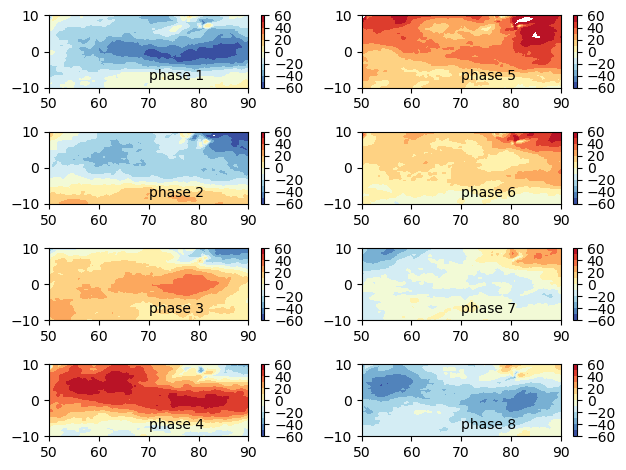

In [171]:
clf()
fig, axs = subplots(4,2)
ctr = fill(contourf(zeros(2,2)), 8)
for i in axes(blhcomp,3) 
    ctr[i] = axs[i].contourf( blhlong[:longitude][:], blhlong[:latitude][:], 
        pd(blhcompa[:,:,i], ),
        vmin=-60, vmax=60, levels=-60:10:60,
        cmap=ColorMap("RdYlBu_r"))
    # title("phase $(i)")
    colorbar(ctr[i])
    axs[i].text(70, -8, "phase $(i)")
    axs[i].set_xlim([50, 90])
end
tight_layout()

savefig("blh_comp_on_omi.png")
gcf()